In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
import PIL.Image as Image 
import matplotlib.image as img

colormap = cm.tab10

A Hopfield Network is a recurrent neural network that stores patterns as attractors of the system. It can be mapped to a spin system with inhomogeneous couplings. We define its energy function:

$
H[S]=-\sum_{i,j} J_{ij}S_i S_j
$

+ where $S_i$ are the neuron states ($+1$ or $-1$)
+ $J_{ij}$ are the synaptic weights
+ The update rule is:

$
S_i (t+1) = sgn(\sum_{j}^{N} J_{ij}S_i S_j)
$

One can store $P$ patterns as a $P$ X $N$-dimensional array of neuron states, i.e. binary patterns ($+1$ and $-1$). 


In [7]:
np.random.seed(1234)

In [8]:
def generate_2D_random_patterns(N, P):
    """ Generate random binary patterns (+1/-1) """
    return np.array([np.where(np.random.rand(int(np.sqrt(N)), int(np.sqrt(N))) > 0.5, 1, -1) for p in range(P)])

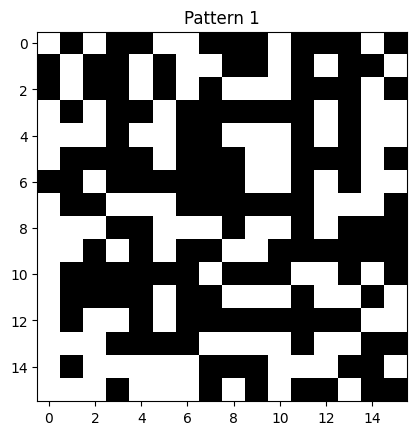

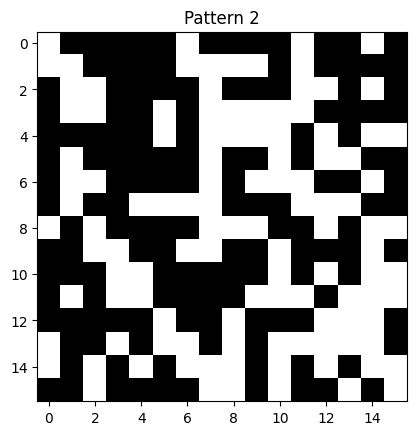

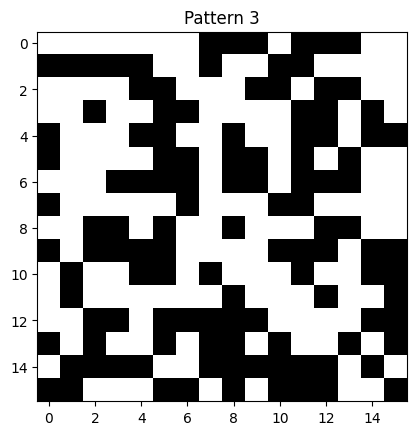

In [9]:
N = 16*16 # Number of spins 
p = 3    # Number of patterns

patterns = generate_2D_random_patterns(N, P=p)
patterns.shape[0]
for p in range(patterns.shape[0]): 
    plt.imshow(patterns[p], cmap='Greys')
    plt.title(f"Pattern {p+1}")
    plt.show()

The synaptic weight matrix can be computed using the Hebbian rule:

$
J_{ij} = \frac{1}{N} \sum_{\mu=1}^{P}\xi_{i}^{\mu}\xi_{j}^{\mu}
$

where $\xi_{i}^{\mu}$ is the $i$-th state for the $\mu$-th pattern, with $i = 1, ..., N$ and $\mu = 1, ..., P$, and the Hebbian rule ensures that if the attractor's configuration is reached, at the successive time step the sign of each spin is maintained.

In [ ]:
def weight_matrix(patterns):
    # Compute Hopfield network weight matrix using Hebbian learning """
    N = patterns.shape[1]
    J = np.zeros((N, N))

    for p in patterns:
        J += np.outer(p, p)
    
    # Normalize by number of neurons and set diagonal to zero
    J /= N
    np.fill_diagonal(J, 0)
    return J

J = weight_matrix(patterns)

ValueError: operands could not be broadcast together with shapes (16,16) (256,256) (16,16) 

At each time step the network iteratively updates the state of the neuron (keeps at its value or flips it) using the following synchronous update rule:

$
S_i = sgn(\sum_{j}^{N}J_{ij}S_j).
$

In [ ]:
def recall_pattern(pattern, J, steps=10):
    """ Retrieve a pattern using synchronous updates """
    S = pattern.copy()
    for _ in range(steps):
        S = np.sign(J @ S)
    return S

Due to the interference of memorized patterns with the retrieval of the input pattern it can be shown that the theoretical storage limit of a Hopfield network is:

$
P_{\max} \approx 0.138 N.
$

For our random patterns we test different values of $P$ and check the accuracy of this simple Hopfield model.

In [ ]:
def assess_storage_capacity(N, max_P, trials=5):
    """ Test recall accuracy for different number of stored patterns """
    capacities = []
    
    for P in range(1, max_P, 5):
        success_count = 0
        for _ in range(trials):
            patterns = generate_random_patterns(N, P)
            J = compute_weight_matrix(patterns)
            
            # Check if all stored patterns are stable
            stable = all(np.all(recall_pattern(p, J) == p) for p in patterns)
            
            if stable:
                success_count += 1
        
        capacities.append((P, success_count / trials))
    
    return np.array(capacities)

capacity_results = assess_storage_capacity(N=100, max_P=50)

# Plot results
plt.plot(capacity_results[:, 0], capacity_results[:, 1], marker="o")
plt.axvline(x=0.138 * 100, color='r', linestyle='--', label="Theoretical limit")
plt.xlabel("Stored Patterns P")
plt.ylabel("Fraction of Successful Retrievals")
plt.title("Storage Capacity of Hopfield Network")
plt.legend()
plt.show()

We can introduce noise by randomly flipping bits in our input pattern and analyze retrieval.

In [ ]:
def introduce_noise(pattern, noise_level):
    """ Flip a fraction of bits in a pattern """
    noisy_pattern = pattern.copy()
    flip_indices = np.random.choice(len(pattern), int(noise_level * len(pattern)), replace=False)
    noisy_pattern[flip_indices] *= -1
    return noisy_pattern

def assess_basins_of_attraction(N, P, noise_levels):
    """ Measure how well patterns are retrieved under different noise levels """
    patterns = generate_random_patterns(N, P)
    J = compute_weight_matrix(patterns)

    retrieval_rates = []
    for noise in noise_levels:
        successful_retrievals = 0
        for p in patterns:
            corrupted_p = introduce_noise(p, noise)
            recovered_p = recall_pattern(corrupted_p, J)
            if np.array_equal(recovered_p, p):
                successful_retrievals += 1
        
        retrieval_rates.append(successful_retrievals / P)
    
    return retrieval_rates

# Define noise levels and test retrieval robustness
noise_levels = np.linspace(0, 0.5, 10)
retrieval_results = assess_basins_of_attraction(N=100, P=10, noise_levels=noise_levels)

# Plot results
plt.plot(noise_levels, retrieval_results, marker="o")
plt.xlabel("Noise Level")
plt.ylabel("Retrieval Accuracy")
plt.title("Basins of Attraction for Different Noise Levels")
plt.show()

Instead of updating all neurons at once, we update one neuron at a time randomly:


S_i(t+1) = \text{sign} \left( \sum_j J_{ij} S_j \right)


However, only one neuron is updated per step. This is called asynchronous update.

In [ ]:
def recall_pattern_asynchronous(pattern, J, steps=100):
    """Retrieve a pattern using asynchronous updates."""
    S = pattern.copy()
    N = len(S)

    for _ in range(steps):
        i = np.random.randint(0, N)  # Select a random neuron
        S[i] = np.sign(np.dot(J[i], S))  # Update only this neuron
    
    return S